# Attention Map Visualization

Set up Initial Params

In [ ]:
save_dir = "./runs"
data_dir = "./data"
patch_size = 7
dim = 512
layers = 3
heads = 8
mlp_dim = dim * 4
multi_query = True
fp_attn = True

Define functions

In [ ]:
from dataset import build_dataset
from medmnist import Evaluator
from medmnist import INFO
import medmnist
import numpy as np
from torchvision import transforms
import torch
import torch
from bitnet.bitlinear import weight_inference_quant
import numpy as np

import argparse
import cv2
import numpy as np
import torch

from bitnet import OneBitViT
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def ternary_ste(w, threshold=0.05):
    w, scale = weight_inference_quant(w)
    return w, scale

def hard_ternary_quantize_model(model, n_channels, threshold=0.05):
    with torch.no_grad():        
        for name, module in model.named_modules():
            
            if module.__class__.__name__ == "BitLinear" and hasattr(module, "weight"):
                w = module.weight
                w_q, scale = ternary_ste(w, threshold)
                module.weight.copy_(w_q)
                module.weight_scale = scale
                module.quant = True
                # print(f"{name}: unique ternary values {np.unique(w_q.detach().cpu().numpy())}")     
               

def remove_bias(model):   
    del model.matcher 
    with torch.no_grad():        
        for name, module in model.named_modules():
            
            if module.__class__.__name__ == "BitLinear" and hasattr(module, "weight"):
                del module.bias
                module.register_parameter('bias', None)

def reshape_transform(tensor, height=32, width=32):
    tensor = tensor[0]
    # return tensor
    # if(tensor.size):
    result = tensor.reshape(1, height, width, tensor.size(-1)).permute(0, 3, 1, 2)
    # Bring the channels to the first dimension,
    # like in CNNs.
    # result = result.transpose(2, 3).transpose(1, 2)
    return result

def get_cam(student, input_tensor, rgb_image, label, target_layers, transform=reshape_transform):
    student.gradcam = True
    # target_layers = [student.norm]

    cam = GradCAM(model=student,
                target_layers=target_layers,
                reshape_transform=transform)

    # If None, returns the map for the highest scoring category.
    # Otherwise, targets the requested category.
    # For example, class index 3
    targets = [ClassifierOutputTarget(label)]


    # AblationCAM and ScoreCAM have batched implementations.
    # You can override the internal batch size for faster computation.
    cam.batch_size = 32
    # input_tensor = preprocess_image(image[0].detach().numpy())
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets,
                        eigen_smooth=True,
                        aug_smooth=True)

    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]

    cam_image = show_cam_on_image(rgb_image, grayscale_cam, image_weight = 0.5, use_rgb=True)
    return cam_image

def get_image(dataset, idx=16):
    info = INFO[dataset]
    DataClass = getattr(medmnist, info['python_class'])
    transform = transforms.Compose([
        transforms.ToTensor(),      
        transforms.Normalize(mean=[.5], std=[.5])   
    ])
    test_dataset = DataClass(split='test', download=True, as_rgb=False, root=data_dir, size=224, mmap_mode='r', transform=transform)
    # print(test_dataset)
    label = test_dataset.labels[idx][0].item()
    rgb_image = test_dataset.imgs[idx] / 255
    nb_classes = len(np.unique(test_dataset.labels))
    if(rgb_image.ndim == 2):
        rgb_image = np.expand_dims(rgb_image, -1)    
    
    n_channels = rgb_image.shape[-1]
    input_tensor = transform(rgb_image).unsqueeze(0).float()
    class_id =  test_dataset.info['label'][str(label)]
    return input_tensor, rgb_image, label, class_id, nb_classes, n_channels


Evaluate GradCam On Student

In [ ]:
# datasets = ["bloodmnist", "organamnist", "organcmnist", "organsmnist", "pneumoniamnist", "retinamnist", "breastmnist", "dermamnist"]
# datasets = ["bloodmnist", "organcmnist", "organsmnist", "pneumoniamnist", "breastmnist", "dermamnist"]
datasets = ["bloodmnist", "pneumoniamnist", "breastmnist", "dermamnist"]
idx_list = [8, 12, 14, 4]

device = 'cuda'

images = []
gradcams = []
class_ids = []

for i in range(len(datasets)):
    
    base_dir = save_dir + ("/multi_query" if multi_query else "/multi_attn") + ("/fp_attn" if fp_attn else "/bit_attn")
    base_dir = base_dir + f'/{datasets[i]}/L{layers}dim{dim}H{heads}'
    OUT_PATH = base_dir + "/bitnet_student.pth"

    idx = idx_list[i]

    input_tensor, rgb_image, label, class_id, nb_classes, n_channels = get_image(datasets[i], idx)
    student = OneBitViT(
        image_size=224,
        patch_size=patch_size,
        num_classes=nb_classes,
        dim=dim,
        depth=layers,
        heads=heads,
        mlp_dim=mlp_dim,
        channels=n_channels,
        dim_head=dim / heads,
        multi_query = multi_query,
        full_precision_attn = fp_attn
    ).to(device)
    state_dict = torch.load(OUT_PATH)
    student.load_state_dict(state_dict)
    hard_ternary_quantize_model(student, n_channels, 0.05)
    remove_bias(student)
    student.eval()
    
    target_layers = [student.transformer.layers[-1][6],student.transformer.layers[-2][6]]

    cam_image = get_cam(student, input_tensor, rgb_image, label, target_layers)
    images.append(rgb_image)
    gradcams.append(cam_image)
    class_ids.append(class_id)

Evaluate GradCam on Teacher ([MedViTv2](https://github.com/Omid-Nejati/MedViTV2))

In [ ]:
from MedViT import MedViT_large
teacher_gradcams = []

for i in range(len(datasets)):
    
    idx = idx_list[i]

    input_tensor, rgb_image, label, class_id, nb_classes, n_channels = get_image(datasets[i], idx)
    if(input_tensor.shape[1] == 1):
        input_tensor = input_tensor.repeat(1,3,1,1)


    teacher = MedViT_large(num_classes = nb_classes)
    checkpoint = torch.load(f"../models/MedViT_large_{datasets[i]}.pth", weights_only=False)
    teacher.load_state_dict(checkpoint["model"])
    teacher.eval().to(device)

    target_layers = [teacher.features[-1].norm2, teacher.features[-4].norm2, teacher.norm]

    cam_image = get_cam(teacher, input_tensor, rgb_image, label, target_layers, None)
    teacher_gradcams.append(cam_image)

initialize_weights...
initialize_weights...
initialize_weights...
initialize_weights...


Create Side-by-Side Comparison

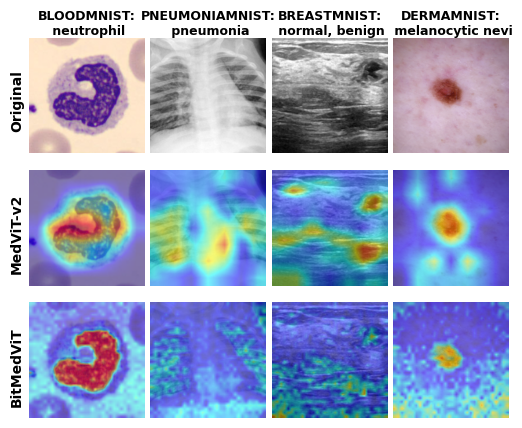

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume `images`, `gradcams`, `teacher_gradcams`, `datasets`, and `class_ids` are defined
num_images = len(images)

# Create subplots without constrained_layout for fine control
fig, axs = plt.subplots(3, num_images, figsize=(1.5 * num_images, 5), constrained_layout=False)

# Ensure axs is 2D array
if num_images == 1:
    axs = np.array(axs).reshape(3, 1)

for i in range(num_images):
    # Row 0: Original grayscale image
    axs[0, i].imshow(images[i], cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title(f"{datasets[i].upper()}:\n {class_ids[i]}", fontsize=9, pad=2, weight='bold')

    # Row 1: Teacher Grad-CAM
    axs[1, i].imshow(teacher_gradcams[i], cmap='jet')
    axs[1, i].axis('off')

    # Row 2: Student Grad-CAM
    axs[2, i].imshow(gradcams[i], cmap='jet')
    axs[2, i].axis('off')

# Add row labels aligned to the left of the subplots
row_labels = ['Original', 'MedViT-v2', 'BitMedViT']
for row_idx, label in enumerate(row_labels):
    # Get y-position for each row in figure coordinates
    y_pos = 0.75 - (row_idx / 1.25) / 3
    # Place the label closer to the axes grid
    fig.text(0.08, y_pos, label, va='center', ha='center', fontsize=10, weight='bold', rotation=90)

# Tighten spacing
plt.subplots_adjust(wspace=0.05, hspace=0.1, left=0.1)
plt.show()


# Teacher Analysis


Evaluation of model flops and accuracies as published. To Run the following code must have everything set up for [MedMamba](https://github.com/YubiaoYue/MedMamba) and [MedViT](https://github.com/Omid-Nejati/MedViT) as well as original MedViTv2 teacher.

In [ ]:
'''
same set up as MedMnist benchmark https://github.com/MedMNIST/experiments/blob/main/MedMNIST2D/models.py
''' 

'''
Adapted from kuangliu/pytorch-cifar .
'''

import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channels=1, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(in_channels, num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], in_channels=in_channels, num_classes=num_classes)


def ResNet50(in_channels, num_classes):
    return ResNet(Bottleneck, [3, 4, 6, 3], in_channels=in_channels, num_classes=num_classes)


from torchvision import transforms
from bitnet.bitlinear import weight_inference_quant
def ternary_ste(w, threshold=0.05):
    w, scale = weight_inference_quant(w)
    return w, scale

def hard_ternary_quantize_model(model, n_channels, threshold=0.05):
    with torch.no_grad():        
        for name, module in model.named_modules():
            
            if module.__class__.__name__ == "BitLinear" and hasattr(module, "weight"):
                w = module.weight
                w_q, scale = ternary_ste(w, threshold)
                module.weight.copy_(w_q)
                module.weight_scale = scale
                module.quant = True
                # print(f"{name}: unique ternary values {np.unique(w_q.detach().cpu().numpy())}")     
               

def remove_bias(model):   
    del model.matcher 
    with torch.no_grad():        
        for name, module in model.named_modules():
            
            if module.__class__.__name__ == "BitLinear" and hasattr(module, "weight"):
                del module.bias
                module.register_parameter('bias', None)
                
def get_image(dataset, idx=16):
    info = INFO[dataset]
    DataClass = getattr(medmnist, info['python_class'])
    transform = transforms.Compose([
        transforms.ToTensor(),      
        transforms.Normalize(mean=[.5], std=[.5])   
    ])
    test_dataset = DataClass(split='test', download=True, as_rgb=True, root='../MedViTV2/data', size=224, mmap_mode='r', transform=transform)
    # print(test_dataset)
    label = test_dataset.labels[idx][0].item()
    rgb_image = test_dataset.imgs[idx] / 255
    nb_classes = len(np.unique(test_dataset.labels))
    if(rgb_image.ndim == 2):
        rgb_image = np.expand_dims(rgb_image, -1)    
    
    n_channels = rgb_image.shape[-1]
    input_tensor = transform(rgb_image).unsqueeze(0).float()
    if(input_tensor.shape[1] == 1):
        input_tensor = input_tensor.repeat(1,3,1,1)
    class_id =  test_dataset.info['label'][str(label)]
    return input_tensor, rgb_image, label, class_id, nb_classes, n_channels

In [4]:
import torch
import torchvision
from MedViTv0 import MedViT_small as MedViTv0_small
from MedViTv0 import MedViT_base as MedViTv0_base
from MedViTv0 import MedViT_large as MedViTv0_large

# medvitv2
from MedViT import MedViT_tiny, MedViT_small, MedViT_base, MedViT_large, MedViT
from medmnist import INFO
from dataset import build_dataset

from fvcore.nn import FlopCountAnalysis
import medmnist 

from bitnet import OneBitViT

from MedMamba import VSSM as medmamba # import model
import numpy as np

def get_model_size(model, packing = True):
    param_size = 0
    total_params = 0
    for name, param in model.named_parameters():
        layer_size = param.nelement() 
        total_params += layer_size
        if(packing and "transformer.layers" in name and "net" in name and "weight" in name and "norm" not in name):
            param_size += layer_size * 0.25
        else:
            param_size += layer_size * param.element_size()

    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb, total_params

datasets = ["chestmnist", "pathmnist", "dermamnist", "octmnist", "pneumoniamnist", "retinamnist", "breastmnist", "bloodmnist", "tissuemnist", "organamnist", "organsmnist"]

all_flops = []
all_sizes = []
all_paras = []

root_dir = "./runs"
patch_size = 7
dim = 512
layers = 3
heads = 8
mlp_dim = dim * 4
multi_query = True
fp_attn = True

models = ["MedViT-S", "MedViT-B", "MedViT-L", "MedViTv2-T", "MedViTv2-S", "MedViTv2-B", "MedViTv2-L", "MedMamba-T", "MedMamba-S", "MedMamba-B"]

for dataset in datasets:

    info = INFO[dataset]
    channels = info["n_channels"]
    classes = len(info['label'])
    # dummy_image, rgb_image, label, class_id, nb_classes, n_channels = get_image(dataset)
    dummy_image = torch.empty(1, 3, 224, 224).to(torch.float).cuda()
    models = [
        # MedViTv0_small(num_classes = classes).cuda().eval(),
        # MedViTv0_base(num_classes = classes).cuda().eval(),
        # MedViTv0_large(num_classes = classes).cuda().eval(),
        # MedViT_tiny(num_classes = classes).cuda().eval(),
        # MedViT_small(num_classes = classes).cuda().eval(),
        # MedViT_base(num_classes = classes).cuda().eval(),
        # MedViT_large(num_classes = classes).cuda().eval(),
        medmamba(depths=[2, 2, 4, 2],dims=[96,192,384,768],num_classes=classes).cuda().eval(),
        medmamba(depths=[2, 2, 8, 2],dims=[96,192,384,768],num_classes=classes).cuda().eval(),
        medmamba(depths=[2, 2, 12, 2],dims=[128,256,512,1024],num_classes=classes).cuda().eval(),
    ]
    
    student = OneBitViT(
        image_size=224,
        patch_size=patch_size,
        num_classes=classes,
        dim=dim,
        depth=layers,
        heads=heads,
        mlp_dim=mlp_dim,
        channels=channels,
        dim_head=dim / heads,
        multi_query = multi_query,
        full_precision_attn = fp_attn
    )
    base_dir = root_dir + ("/multi_query" if multi_query else "/multi_attn") + ("/fp_attn" if fp_attn else "/bit_attn")
    base_dir = base_dir + f'/{dataset}/L{layers}dim{dim}H{heads}'


    MODEL_PATH = base_dir + "/bitnet_student.pth"
    # state_dict = torch.load(MODEL_PATH)
    # student.load_state_dict(state_dict)
    # hard_ternary_quantize_model(student, channels, 0.05)
    # remove_bias(student)
    # student.eval()
    
    channel_dependent_models = [
        # ResNet18(channels, classes).cuda(),
        # ResNet50(channels, classes).cuda(),
        # student.cuda()
    ]
    
    flops = []
    sizes = []
    paras = []

    for model in models:
        cur_flops = FlopCountAnalysis(model, (dummy_image, )).total()
        
        size, cur_paras = get_model_size(model, packing=False)

        flops.append(cur_flops)
        sizes.append(size)
        paras.append(cur_paras)

    for model in channel_dependent_models:
        # cur_flops = FlopCountAnalysis(model, (dummy_image[:, :channels], )).total()
        size, cur_paras = get_model_size(model, packing=False)

        flops.append(cur_flops)
        sizes.append(size)
        paras.append(cur_paras)


    all_flops.append(flops)
    all_sizes.append(sizes)
    all_paras.append(paras)

    # task = info['task']
    # DataClass = getattr(medmnist, info['python_class'])

    # test_dataset = DataClass(split='test', download=True, as_rgb=True, root='MedViTV2/data', size=224, mmap_mode='r')


/home/miki/anaconda3/envs/iccad_2025_v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/miki/anaconda3/envs/iccad_2025_v2/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/miki/anaconda3/envs/iccad_2025_v2/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/miki/ICCAD/bitnet/MedViT.py:592: UserWarning: Overwriting MedViT_small in registry with MedViT.MedViT_small. This is b

torch.Size([1, 6])


In [5]:
mean_flops = torch.tensor(all_flops).to(torch.float).mean(0)
mean_sizes = torch.tensor(all_sizes).to(torch.float).mean(0)
mean_paras = torch.tensor(all_paras).to(torch.float).mean(0)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Data
MedViT_acc = np.array([
    [0.938, 0.956, 0.768, 0.767, 0.949, 0.534, 0.897, 0.965, 0.673, 0.951, 0.912, 0.778],
    [0.942, 0.954, 0.780, 0.782, 0.961, 0.561, 0.901, 0.965, 0.686, 0.952, 0.920, 0.786],
    [0.933, 0.959, 0.773, 0.761, 0.921, 0.552, 0.885, 0.964, 0.683, 0.951, 0.920, 0.787]
])
MedViT_avg = MedViT_acc.mean(axis=1)
MedViT_params = np.array([31.1e6, 44.4e6, 57.6e6])
MedViT_flops = np.array([11.7e9, 16.7e9, 21.6e9])

MedMamba_acc = np.array([
    [0.953, 0.779, 0.918, 0.899, 0.543, 0.853, 0.978, 0.946, 0.927, 0.819],
    [0.955, 0.758, 0.929, 0.936, 0.545, 0.853, 0.984, 0.959, 0.944, 0.833],
    [0.964, 0.757, 0.927, 0.925, 0.553, 0.891, 0.983, 0.964, 0.943, 0.834]
])
MedMamba_avg = MedMamba_acc.mean(axis=1)
MedMamba_params = np.array([14.5e6, 22.8e6, 72.3e6])
MedMamba_flops = np.array([4.5e9, 6.1e9, 15.6e9])

MedViTv2_acc = np.array([
    [0.959, 0.963, 0.781, 0.927, 0.951, 0.547, 0.882, 0.979, 0.696, 0.958, 0.935, 0.824],
    [0.965, 0.964, 0.792, 0.942, 0.965, 0.562, 0.895, 0.985, 0.705, 0.966, 0.950, 0.839],
    [0.970, 0.964, 0.808, 0.944, 0.969, 0.575, 0.904, 0.985, 0.711, 0.969, 0.953, 0.844],
    [0.977, 0.967, 0.817, 0.952, 0.973, 0.578, 0.910, 0.987, 0.716, 0.973, 0.961, 0.851]
])
MedViTv2_avg = MedViTv2_acc.mean(axis=1)
MedViTv2_params = np.array([12.3e6, 32.3e6, 72.3e6, 162.9e6])
MedViTv2_flops = np.array([5.1e9, 7.6e9, 15.6e9, 25.12e9])

resnet_acc = np.array([
    [0.909, 0.947, 0.754, 0.763, 0.864, 0.493, 0.833, 0.963, 0.681, 0.951, 0.920, 0.778],
    [0.892, 0.948, 0.731, 0.776, 0.884, 0.511, 0.828, 0.963, 0.683, 0.940, 0.913,0.782]
])
resnet_avg = resnet_acc.mean(axis=1)
resnet_params = np.array([25.6 * 10 ** 6, 50 * 10 ** 6])
resnet_flops = np.array([4 * 10 ** 9, 7.6 * 10 **9])


student_acc = np.array([
    [0.99, 0.94, 0.79, 0.95, 0.86, 0.53, 0.87, 0.97, 0.64, 0.98, 0.96, 0.81]
])

student_auc = np.array([
    [1.00, 0.72, 0.95, 0.99, 0.98, 0.81, 0.91, 1.00, 0.92, 1.00, 1.00, 0.99]
])

student_avg = student_acc.mean(axis=1)
student_params = np.array([8.645 * 10 ** 6])
student_flops = np.array([11.53 * 10 ** 9])

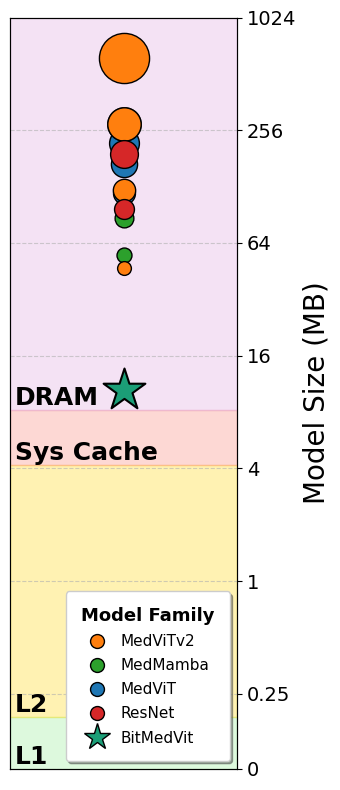

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

# ---- Dummy Data Placeholder (replace with real values) ----
# MedViT_params = np.array([...])
# MedViT_flops = np.array([...])
# MedViT_avg = np.array([...])
# MedMamba_params = ...
# ...

# Combine all data
all_params = np.concatenate([MedViT_params, MedMamba_params, MedViTv2_params, resnet_params])
all_flops = np.concatenate([MedViT_flops, MedMamba_flops, MedViTv2_flops, resnet_flops]) / 1e9  # in B
all_acc = np.concatenate([MedViT_avg, MedMamba_avg, MedViTv2_avg, resnet_avg]) * 100            # in %

# Colors for each model family
colors = {
    'MedViT': '#1f77b4',
    'MedMamba': '#2ca02c',
    'MedViTv2': '#ff7f0e',
    'ResNet': '#d62728',
    'BitMedVit': '#1b9e77',
    
}

# Assign colors to each data point
all_colors = (
    [colors['MedViT']] * len(MedViT_avg) +
    [colors['MedMamba']] * len(MedMamba_avg) +
    [colors['MedViTv2']] * len(MedViTv2_avg) +
    [colors['ResNet']] * len(resnet_avg)
)

# Convert parameters to MB
PARAMS_TO_MB = 4 / (1024 ** 2)  # ~0.0038147 MB per parameter
all_params_mb = all_params * PARAMS_TO_MB
point_sizes = (all_params / 1e6) * 8  # marker size scaling

# Memory limits in MB
L1_LIMIT = 192 / 1024      # ~0.1875 MB
L2_LIMIT = 4               # 4 MB
L3_LIMIT = 4         # System cache or L3
DRAM_LIMIT = 8 * 1024      # 8 GB

# Create figure and layout
fig, ax0 = plt.subplots(figsize=(3.5, 8))

ax0.set_yticks([])
ax0 = ax0.twinx()
# Region Labels (bottom-left of each region)
ax0.text(0.52, 0.1, 'L1', fontsize=18, fontweight='bold', ha='left', va='bottom')
ax0.text(0.52, L1_LIMIT, 'L2', fontsize=18, fontweight='bold', ha='left', va='bottom')
ax0.text(0.52, L1_LIMIT + L2_LIMIT, 'Sys Cache', fontsize=18, fontweight='bold', ha='left', va='bottom')
ax0.text(0.52, L1_LIMIT + L2_LIMIT + L3_LIMIT, 'DRAM', fontsize=18, fontweight='bold', ha='left', va='bottom')

# Scatter plot of model sizes
for i in range(len(all_params_mb)):
    ax0.scatter(1, all_params_mb[i], s=point_sizes[i], color=all_colors[i],
                edgecolor='black', alpha=1, zorder=3)

# Highlight memory regions
ax0.axhspan(0, L1_LIMIT, color='lightgreen', alpha=0.3, zorder=0)
ax0.axhspan(L1_LIMIT, L1_LIMIT + L2_LIMIT, color='gold', alpha=0.3, zorder=0)
ax0.axhspan(L1_LIMIT + L2_LIMIT, L1_LIMIT + L2_LIMIT + L3_LIMIT, color='salmon', alpha=0.3, zorder=0)
ax0.axhspan(L1_LIMIT + L2_LIMIT + L3_LIMIT, L1_LIMIT + L2_LIMIT + L3_LIMIT + DRAM_LIMIT, color='plum', alpha=0.3, zorder=0)

# Axis formatting
ax0.set_xticks([])
ax0.set_xlim(0.5, 1.5)
ax0.set_yscale('log', base=2)
ax0.set_ylim(0, 1024)
ax0.set_yticks([])
ax0.grid(True, axis='y', linestyle='--', alpha=0.6)

# Y-ticks as powers of 2
ax0.set_ylabel('Model Size (MB)', fontsize=20)
ax0.set_ylim(0, 1024)
yticks = [0.1] + [2**i for i in range(-2, 11, 2)]  # 2^-6 to 2^13
ax0.set_yscale('log', base=2)
ax0.set_yticks(yticks)
ax0.tick_params(axis='y', labelsize=14)
ax0.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}' if y == int(y) else float(y) if y > 0.1  else 0))

# After your existing scatter loop for all_params_mb, add this:

# Example: your model's parameter count (replace with actual value)
my_model_params_mb = 10.5
my_model_point_size = 1000  # *2 to make it bigger than others

ax0.scatter(1, my_model_params_mb, s=my_model_point_size, 
            color=colors['BitMedVit'], edgecolor='black', marker='*', linewidth=1.5, alpha=1, zorder=5)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='MedViTv2', markerfacecolor=colors['MedViTv2'], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='MedMamba', markerfacecolor=colors['MedMamba'], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='MedViT', markerfacecolor=colors['MedViT'], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='ResNet', markerfacecolor=colors['ResNet'], markersize=10, markeredgecolor='black'),
    Line2D([0], [0], marker='*', color='w', label='BitMedVit', markerfacecolor=colors['BitMedVit'], markersize=20, markeredgecolor='black'),
]

legend = ax0.legend(
    handles=legend_elements,
    title='Model Family',
    loc='lower right',
    fontsize=11,
    title_fontsize=13,
    frameon=True,
    shadow=True,
    borderpad=1,
    labelspacing=0.6,
    handletextpad=0.8,
    handlelength=1.5,
    fancybox=True
)

# Optional: make the legend title bold
legend.get_title().set_fontweight('bold')

# --- Right subplot: Accuracy vs FLOPs ---
# Layout
plt.tight_layout()
plt.show()


In [12]:
MedViTv2_flops

array([5.100e+09, 7.600e+09, 1.560e+10, 2.512e+10])

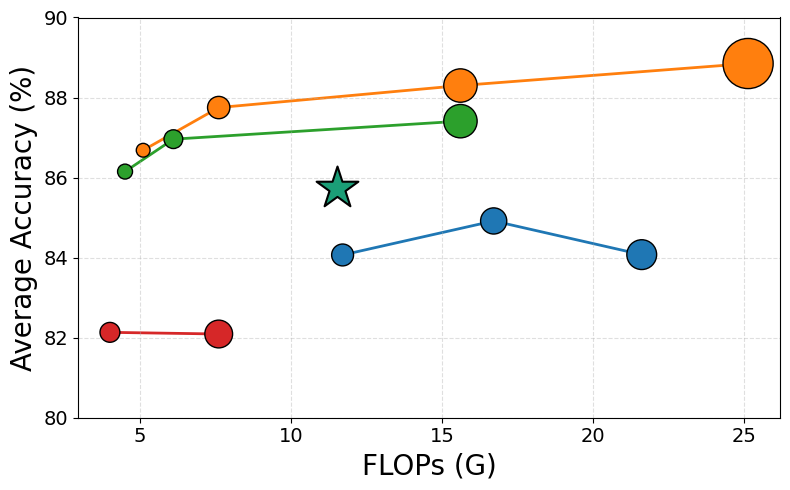

In [13]:

fig, ax1 = plt.subplots(figsize=(8, 5))
# Plot lines per model family
ax1.plot(MedViT_flops / 1e9, MedViT_avg * 100, color=colors['MedViT'], linewidth=2, zorder=1)
ax1.plot(MedMamba_flops / 1e9, MedMamba_avg * 100, color=colors['MedMamba'], linewidth=2, zorder=1)
ax1.plot(MedViTv2_flops / 1e9, MedViTv2_avg * 100, color=colors['MedViTv2'], linewidth=2, zorder=1)
ax1.plot(resnet_flops / 1e9, resnet_avg * 100, color=colors['ResNet'], linewidth=2, zorder=1)

# Scatter points
ax1.scatter(all_flops, all_acc, s=point_sizes, c=all_colors,
            edgecolor='black', alpha=1.0, zorder=2)

ax1.scatter(student_flops / 1e9, student_avg * 100, s=my_model_point_size, 
            color=colors['BitMedVit'], edgecolor='black', marker='*', linewidth=1.5, alpha=1, zorder=5)

# Labels & formatting
ax1.set_xlabel('FLOPs (G)', fontsize=20)
ax1.set_ylabel('Average Accuracy (%)', fontsize=20)
# ax1.set_title('Accuracy vs Computation\n(Marker Size ∝ Parameters)', fontsize=13)
# ax1.set_xlim(0, 30)
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.set_ylim(80, 90)

# Legend

plt.tight_layout()
plt.show()

# MSE vs MHSA

In [8]:
import numpy as np

mhsa_accuracies = np.array([0.9731, 0.8077, 0.9402, 0.7822, 0.9496, 0.9729, 0.9582, 0.7989, 0.9913, 0.8969, 0.525, 0.653])
mhsa_params = np.array([10093113, 10039859, 10046015, 10092600, 10040885, 10044476, 10044476, 10044476, 10093626, 10039859, 10091574, 10042937])

mqa_accuracies = np.array([0.9749, 0.8718, 0.9393, 0.7876, 0.9476, 0.9769, 0.9645, 0.8148, 0.9911, 0.8588, 0.525, 0.6369])
mqa_params = np.array([8665532, 8665532, 8714169, 8714169, 8713656, 8661941, 8665532, 8665532, 8665532, 8714682, 8660915, 8712630])



In [5]:
bitlinear_params = 3 * (512 * 2048 * 2)

mean_mqa_accuracy = np.mean(mqa_accuracies)
mean_mqa_params = np.mean(mqa_params) - bitlinear_params

mean_mhsa_avg_accuracy = np.mean(mhsa_accuracies)
mean_mhsa_params = np.mean(mhsa_params) - bitlinear_params

In [45]:
# Example data (replace with your actual variables)
bitlinear_params = 3 * ((512 + 1) * 2048 + (2048 + 1) * 512)          # FeedForward (shared)
q_projection = 3 * (512 * (512 + 1))
post_attention_projection = 3 * (512 * (512 + 1))

kv_mqa_params = (2 * 512 * (512 + 1) * 3) / 8          # New KV projection values
kv_mhsa_params = (2 * 512 * (512 + 1) * 3)

mean_mqa_accuracy = np.mean(mqa_accuracies) * 100
mean_mqa_params = np.mean(mqa_params)

mean_mhsa_avg_accuracy = np.mean(mhsa_accuracies) * 100
mean_mhsa_params = np.mean(mhsa_params)

models = ["MHSA", "MQA"]
accuracies = [mean_mhsa_avg_accuracy, mean_mqa_accuracy]

other_layers_params = [
    mean_mhsa_params - (bitlinear_params + q_projection + post_attention_projection + kv_mhsa_params),
    mean_mqa_params - (bitlinear_params + q_projection + post_attention_projection + kv_mqa_params),
]

other_layers = other_layers_params
feedforward = [bitlinear_params, bitlinear_params]
q_proj = [q_projection, q_projection]
post_attention = [post_attention_projection, post_attention_projection]
kv_proj = [kv_mhsa_params, kv_mqa_params]


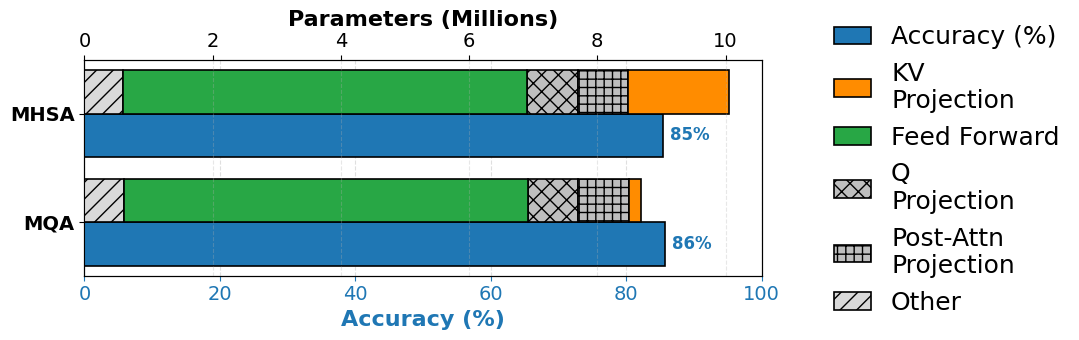

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Reverse order
models = ["MHSA", "MQA"]
accuracies = [mean_mhsa_avg_accuracy, mean_mqa_accuracy]

other_millions = np.array([
    mean_mhsa_params - (bitlinear_params + q_projection + post_attention_projection + kv_mhsa_params),
    mean_mqa_params - (bitlinear_params + q_projection + post_attention_projection + kv_mqa_params),
]) / 1e6
feedforward_millions = np.array([bitlinear_params, bitlinear_params]) / 1e6
q_proj_millions = np.array([q_projection, q_projection]) / 1e6
post_attention_millions = np.array([post_attention_projection, post_attention_projection]) / 1e6
kv_millions = np.array([kv_mhsa_params, kv_mqa_params]) / 1e6

models = models[::-1]
accuracies = accuracies[::-1]
other_millions = other_millions[::-1]
feedforward_millions = feedforward_millions[::-1]
q_proj_millions = q_proj_millions[::-1]
post_attention_millions = post_attention_millions[::-1]
kv_millions = kv_millions[::-1]

# Colors
color_acc = "#1f77b4"           # Blue - highlight
color_other = "#d9d9d9"         # Muted gray
color_feedforward = "#28a745"   # Vibrant green
color_q = "#bfbfbf"             # Muted gray
color_post_attention = "#bfbfbf" # Muted gray
color_kv = "#ff8c00"            # Distinct orange

# Lighter hatch patterns
hatch_other = '//'
hatch_q = 'xx'
hatch_post = '++'

fig, ax1 = plt.subplots(figsize=(8, 3.5))
y = np.arange(len(models))
bar_height = 0.4

# Accuracy bars
acc_bars = ax1.barh(y - bar_height / 2, accuracies, height=bar_height, color=color_acc,
                    edgecolor='black', linewidth=1.2, label="Accuracy (%)", zorder=3)
ax1.set_xlabel("Accuracy (%)", color=color_acc, fontsize=16, fontweight='bold')
ax1.set_xlim(0, 100)
ax1.tick_params(axis='x', colors=color_acc, labelsize=14)
ax1.set_yticks(y)
ax1.set_yticklabels(models, fontsize=14, fontweight='bold')
ax1.grid(axis='x', linestyle='--', alpha=0.4, zorder=0)

for rect in acc_bars:
    width = rect.get_width()
    ax1.text(width + 1, rect.get_y() + rect.get_height()/2,
             f"{width:.0f}%", va='center', fontsize=12,
             color=color_acc, fontweight='bold')

# Parameters stacked bars
ax2 = ax1.twiny()
bottom_other = np.zeros_like(other_millions)
bottom_feedforward = other_millions
bottom_q_proj = other_millions + feedforward_millions
bottom_post_attention = other_millions + feedforward_millions + q_proj_millions
bottom_kv = other_millions + feedforward_millions + q_proj_millions + post_attention_millions

# Muted bars with lighter hatches
bar_other = ax2.barh(y + bar_height/2, other_millions, height=bar_height, color=color_other, edgecolor='black',
                      linewidth=1.2, hatch=hatch_other, label="Other")
bar_q = ax2.barh(y + bar_height/2, q_proj_millions, left=bottom_q_proj, height=bar_height, color=color_q,
                 edgecolor='black', linewidth=1.2, hatch=hatch_q, label="Q\nProjection")
bar_post = ax2.barh(y + bar_height/2, post_attention_millions, left=bottom_post_attention, height=bar_height,
                    color=color_post_attention, edgecolor='black', linewidth=1.2, hatch=hatch_post, label="Post-Attn\nProjection")

# Highlighted bars with vibrant colors
bar_feedforward = ax2.barh(y + bar_height/2, feedforward_millions, left=bottom_feedforward, height=bar_height, 
                            color=color_feedforward, edgecolor='black', linewidth=1.2, label="Feed\nForward")
bar_kv = ax2.barh(y + bar_height/2, kv_millions, left=bottom_kv, height=bar_height, 
                  color=color_kv, edgecolor='black', linewidth=1.2, label="KV Projection")

ax2.set_xlabel("Parameters (Millions)", color='black', fontsize=16, fontweight='bold')
ax2.tick_params(axis='x', colors='black', labelsize=14)
ax2.grid(axis='x', linestyle='--', alpha=0.3, zorder=0)

# Manually reorder legend
handles = [acc_bars, bar_kv, bar_feedforward, bar_q, bar_post, bar_other]
labels = ["Accuracy (%)", "KV Projection", "Feed Forward", "Q Projection", "Post-Attn\nProjection", "Other"]

fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5),
           fontsize=18, frameon=False, handlelength=1.5, columnspacing=1.2)

fig.subplots_adjust(right=0.75)
fig.tight_layout()
plt.show()
